In [31]:
import matplotlib.pyplot as plt
import tensorflow as tf
from imutils import paths
import numpy as np
import sys
import cv2
import os

sys.path.append("..")

from bodypose.training.metrics import avgMDE_2D, avgMDE_2D_RAW, Accuracy
from bodypose.training.metrics import RegressionLoss2D, AuxiliaryLoss
from bodypose.training.preprocessing import load_TFRecords_dataset  
from bodypose.training.preprocessing import augmentations
from bodypose.training.architecture import MoveNet
from bodypose.demo.graphics import draw_keypoints
from bodypose.training.architecture.custom_layers import get_max_mask

import config as cfg

In [2]:
INPUT_SHAPE = (224, 224, 3)
STRIDES = (32, 16, 8, 4)
NUM_KPTS = cfg.N_KPTS

GRID_SIZE = INPUT_SHAPE[0] // STRIDES[-1]

In [3]:
filePaths = list(paths.list_files("../test/tfrecs/"))
print(f"[INFO] Found {len(filePaths)} TFRecords.")

ds = load_TFRecords_dataset(
    filePaths=filePaths, 
    batch_size = 1,
    target_size = INPUT_SHAPE[:2],
    grid_dim = GRID_SIZE,
    augmentations = [],
    roi_thresh = 0.9
    )

[INFO] Found 1 TFRecords.


2022-11-03 11:37:53.687934: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
model = MoveNet(
    input_shape = INPUT_SHAPE, 
    strides = STRIDES, 
    num_joints = NUM_KPTS, 
    alpha = .25, 
    use_depthwise = True
    )

img = (np.random.uniform(
    0, 255, (1,) + INPUT_SHAPE
    ).astype("uint8") / 255).astype(np.float32)

%timeit model(img)

123 ms ± 11.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
for img, (y1, y2) in ds.take(1):
    kpts, heatmaps, w_heatmaps = model(img)
    kpts = kpts[0].numpy()
    heatmaps  = heatmaps[0].numpy()

print(kpts)

[[0.03696707 0.5446429  0.43749505 0.50019395 0.4993993 ]
 [0.03693591 0.45535788 0.4732178  0.49985242 0.49947104]
 [0.03752458 0.5803564  0.49107185 0.5012978  0.49959522]
 [0.03710921 0.41963723 0.47322124 0.4996698  0.49940327]
 [0.037021   0.45535588 0.5089315  0.49951023 0.49984315]
 [0.03737743 0.4553569  0.5624976  0.4993153  0.50056523]
 [0.0369078  0.49107325 0.56250054 0.50004435 0.5002435 ]
 [0.03733764 0.5982153  0.508928   0.50115466 0.5000382 ]
 [0.03714565 0.58035773 0.4732153  0.50071853 0.4996795 ]
 [0.03694103 0.50893205 0.5803609  0.5001013  0.5002748 ]
 [0.03695603 0.5089276  0.5624976  0.49998567 0.500338  ]
 [0.03681903 0.6517762  0.4732189  0.50032926 0.49972463]
 [0.03703326 0.47321656 0.562502   0.499862   0.5004627 ]
 [0.03743017 0.40177682 0.4910712  0.49928454 0.4992757 ]
 [0.03679266 0.4374996  0.4553539  0.49990517 0.4997077 ]
 [0.03727325 0.5982185  0.52678907 0.5009377  0.49965188]
 [0.03747146 0.41964006 0.5089295  0.4990859  0.5001199 ]]


1/1 [==============================] - 0s 57ms/step


Text(0.5, 1.0, 'Weighted Keypointsmap')

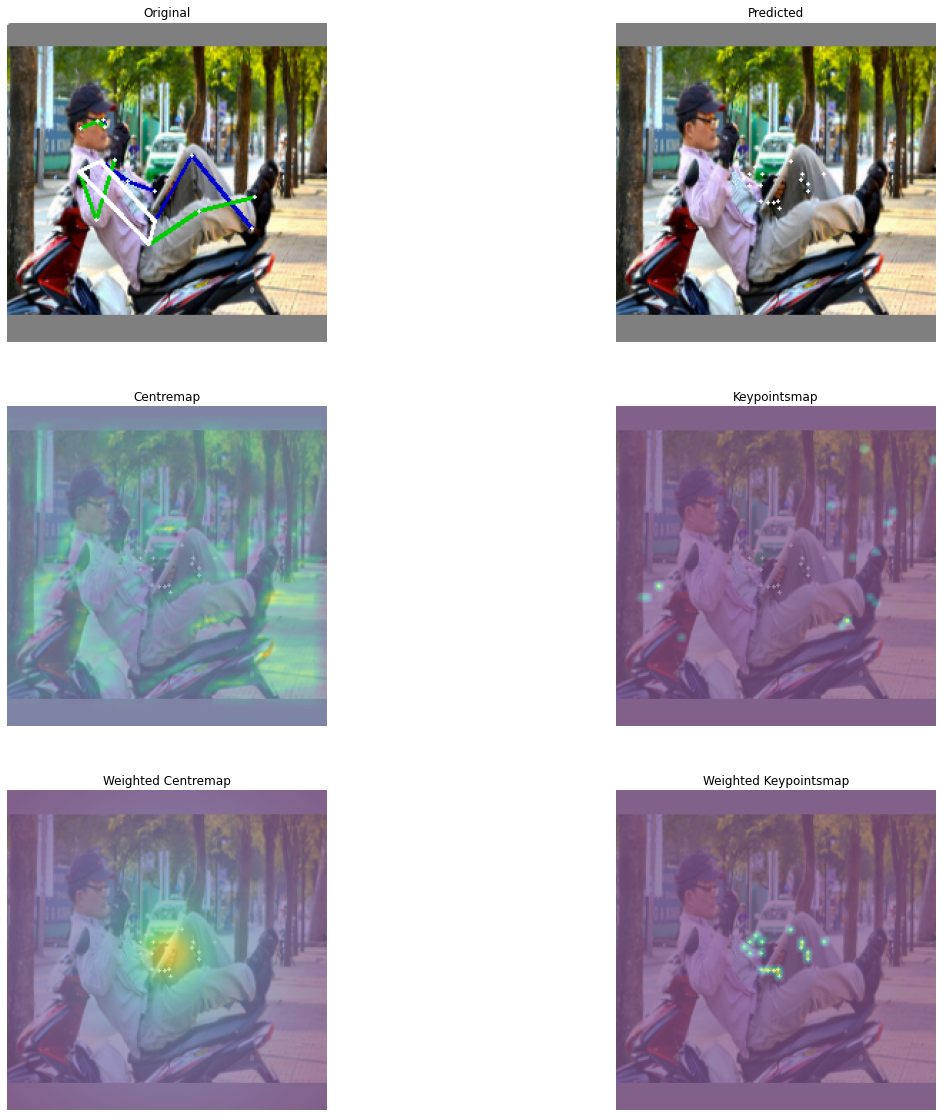

In [43]:

i=0
pred_img = ((img[i].numpy() + 1) * 127.5).astype('uint8').copy()
true_img = ((img[i].numpy() + 1) * 127.5).astype('uint8').copy()

preds, heatmaps, w_heatmaps = model.predict(img[i:i+1])
preds = preds[0, :, :3]
preds = preds[:, [1,2,0]]

# Heatmaps
kptsmask = get_max_mask(heatmaps.reshape(-1, 56, 56, 18))
kptsmap = kptsmask[0, :, :, 1:].numpy().sum(axis=-1)
kptsmap = cv2.resize(kptsmap, INPUT_SHAPE[:2])

centremap = heatmaps[0, :, 0].reshape(56, 56)
centremap = cv2.resize(centremap, INPUT_SHAPE[:2])

# Weighted heatmaps
w_kptsmask = get_max_mask(w_heatmaps.reshape(-1, 56, 56, 18))
w_kptsmap = w_kptsmask[0, :, :, 1:].numpy().sum(axis=-1)
w_kptsmap = cv2.resize(w_kptsmap, INPUT_SHAPE[:2])

w_centremap = w_heatmaps[0, :, 0].reshape(56, 56)
w_centremap = cv2.resize(w_centremap, INPUT_SHAPE[:2])


labels = y1[i, :, :3].numpy()
labels = labels[:, [1,2,0]]

pred_img = draw_keypoints(pred_img, preds, .5)
true_img = draw_keypoints(true_img, labels, .5)

fig, axs = plt.subplots(3, 2)
fig.set_figheight(20)
fig.set_figwidth(20)

axs[0,0].imshow(true_img)
axs[0,0].axis('off')
axs[0,0].set_title("Original")

axs[0,1].imshow(pred_img)
axs[0,1].axis('off')
axs[0,1].set_title("Predicted")

axs[1,0].imshow(pred_img, alpha=.5)
axs[1,0].imshow(centremap,  alpha=.5)
axs[1,0].axis('off')
axs[1,0].set_title("Centremap")

axs[1,1].imshow(pred_img, alpha=.5)
axs[1,1].imshow(kptsmap,  alpha=.5)
axs[1,1].axis('off')
axs[1,1].set_title("Keypointsmap")

axs[2,0].imshow(pred_img, alpha=.5)
axs[2,0].imshow(w_centremap,  alpha=.5)
axs[2,0].axis('off')
axs[2,0].set_title("Weighted Centremap")

axs[2,1].imshow(pred_img, alpha=.5)
axs[2,1].imshow(w_kptsmap,  alpha=.5)
axs[2,1].axis('off')
axs[2,1].set_title("Weighted Keypointsmap")

In [37]:
kptsmask.shape

TensorShape([1, 56, 56, 18])